# Generating a skewed FC

Following a question on the mailing list about uniformly symmetric simulated functional connectivity, it would be interesting to take a look at generating a more skewed FC.  The question is about the Reduced Wong-Wang model, so let's take a quick look at its phase plane,

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
from tvb.simulator.lab import *

To look at the shifts due to coupling, we can do a few simulations,

WARNING  File 'hemispheres' not found in ZIP.


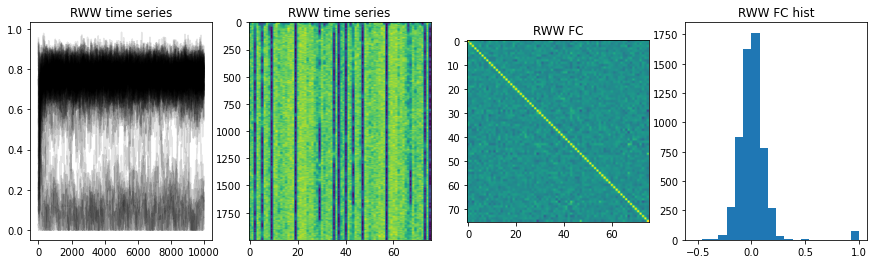

In [2]:
conn76 = connectivity.Connectivity.from_file()
def run(a, I=0.32, sig=1e-5, T=1e3):
    rww = models.ReducedWongWang(a=numpy.array([0.27]), w=numpy.array([1.0]), I_o=numpy.array([I]))
    sim = simulator.Simulator(
        model=rww,
        connectivity=conn76,
        coupling=coupling.Linear(a=numpy.array([a / len(conn76.weights)])),
        integrator=integrators.HeunStochastic(dt=5,
            noise=noise.Additive(nsig=numpy.array([sig]))), 
        monitors=(monitors.TemporalAverage(period=5.),),
        simulation_length=T
    ).configure()
    (time, data), = sim.run()
    return time, data[:, 0, :, 0]

t, y = run(1.0, sig=0.0001, I=0.28, T=10e3)
plt.figure(figsize=(15, 4))
plt.subplot(141); plt.plot(t, y, 'k', alpha=0.1); plt.title('RWW time series')
plt.subplot(142); plt.imshow(y, aspect='auto'); plt.title('RWW time series')
plt.subplot(143); plt.imshow(numpy.corrcoef(y[t>(t[-1]/2)].T), vmin=-1, vmax=1); plt.title('RWW FC')
plt.subplot(144); plt.hist(numpy.corrcoef(y[t>(t[-1]/2)].T).flat, 20); plt.title('RWW FC hist');

Despite varying coupling scaling, excitability shifts, noise strengths (by hand or optimization), the steady state FC is always very close to normally distributed, centered at zero, consistent with the fixed point structure of the model.  Models with intrinsic fluctuations like oscillators can however express fluctuations required to have a shifted or skewed FC:

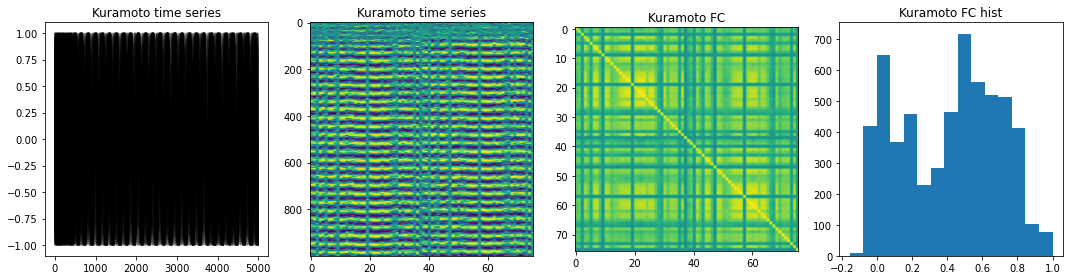

In [3]:
osc = models.Kuramoto(omega=numpy.r_[0.35])
def run2(a = 0.1, sig = 1e-4, T = 1e3):
    sim = simulator.Simulator(
        model=osc,
        connectivity=conn76,
        coupling=coupling.Kuramoto(a=numpy.array([a / len(conn76.weights)])),
        integrator=integrators.HeunStochastic(dt=1,
            noise=noise.Additive(nsig=numpy.array([sig]))), 
        monitors=(monitors.TemporalAverage(period=5.),),
        simulation_length=T
    ).configure()
    (time, data), = sim.run()
    return time, data[:, 0, :, 0]


t, y = run2(a=1.5, sig=0.1, T=5e3)
y = numpy.sin(y)
plt.figure(figsize=(15, 4))
plt.subplot(141); plt.plot(t, y, 'k', alpha=0.1); plt.title('Kuramoto time series')
plt.subplot(142); plt.imshow(y, aspect='auto'); plt.title('Kuramoto time series')
plt.subplot(143); plt.imshow(numpy.corrcoef(y[t>(t[-1]/2)].T), vmin=-1, vmax=1); plt.title('Kuramoto FC')
plt.subplot(144); plt.hist(numpy.corrcoef(y[t>(t[-1]/2)].T).flat, 15); plt.title('Kuramoto FC hist')
plt.tight_layout()